In [1]:
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


import numpy as np

# Datasets

## Watershed Frequency Dataset

In [2]:
watershed_frequency_path = r'KY_WatershedEventFrequencies_26916.csv'

df_watersheds = pd.read_csv(watershed_frequency_path)

df_watersheds['geometry'] = gpd.GeoSeries.from_wkt(df_watersheds['geometry'])

gdf_watersheds = gpd.GeoDataFrame(df_watersheds, geometry='geometry')

gdf_watersheds.head(3)

,loaddate,areasqkm,huc10,name,geometry,gauge,moe99_freq_gh,percentile90_freq_gh,percentile99_freq_gh,moe99_freq_sf,percentile90_freq_sf,percentile99_freq_sf,moe99_freq_gh_cat,moe99_freq_sf_cat,percentile90_freq_gh_cat,percentile90_freq_sf_cat,percentile99_freq_gh_cat,percentile99_freq_sf_cat
0,2023-04-03,580.98,507020303,Johns Creek,"POLYGON ((881893.974 4190800.677, 881967.969 4...",1,81.522059,43.305147,6.823529,39.620000,26.680000,3.720000,20.1-81.5,21.0-47.2,41.4-47.5,16.0-28.2,3.9-7.1,2.5-5.9
1,2016-07-29,466.16,509010110,Symmes Creek-Ohio River,"POLYGON ((894401.028 4297112.227, 894422.866 4...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-03-30,834.17,510010111,Johnson Creek-Licking River,"POLYGON ((744167.531 4274338.915, 744182.905 4...",1,107.882353,42.882353,7.411765,99.347826,44.869565,8.304348,100.1-140.1,86.9-128.5,41.4-47.5,38.7-45.6,7.1-12.0,5.9-9.8


In [3]:
# create reduced subset geodataframe for ease of use...
# geodataframe with huc10 id, geometry, and frequencies estimated from gauge height/flood stage data
gdf_ws = gdf_watersheds[['huc10', 'geometry', 'moe99_freq_gh', 'percentile90_freq_gh', 'percentile99_freq_gh']].copy()

# standardize frequencies for gauge height frequencies
for freq_col in [col for col in gdf_ws.columns if 'gh' in col]:

    scaler = StandardScaler()
    data = gdf_ws[freq_col].to_numpy().reshape(-1,1)
    X_scaled = scaler.fit_transform(data)
    
    new_col_name = freq_col + '_std'
    gdf_ws.loc[:, new_col_name] = X_scaled

# repeat for streamflow/discharge data...
gdf_ws[['moe99_freq_sf', 'percentile90_freq_sf', 'percentile99_freq_sf']] = gdf_watersheds[['moe99_freq_sf', 'percentile90_freq_sf', 'percentile99_freq_sf']].copy()
for freq_col in [col for col in gdf_ws.columns if 'sf' in col]:
    scaler = StandardScaler()
    data = gdf_ws[freq_col].to_numpy().reshape(-1,1)
    X_scaled = scaler.fit_transform(data)
    new_col_name = freq_col + '_std'
    gdf_ws.loc[:, new_col_name] = X_scaled

gdf_ws.head()

,huc10,geometry,moe99_freq_gh,percentile90_freq_gh,percentile99_freq_gh,moe99_freq_gh_std,percentile90_freq_gh_std,percentile99_freq_gh_std,moe99_freq_sf,percentile90_freq_sf,percentile99_freq_sf,moe99_freq_sf_std,percentile90_freq_sf_std,percentile99_freq_sf_std
0,507020303,"POLYGON ((881893.974 4190800.677, 881967.969 4...",81.522059,43.305147,6.823529,-0.559426,0.033010,-0.334038,39.620000,26.680000,3.720000,-0.915059,-1.545175,-0.906152
1,509010110,"POLYGON ((894401.028 4297112.227, 894422.866 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510010111,"POLYGON ((744167.531 4274338.915, 744182.905 4...",107.882353,42.882353,7.411765,1.026374,-0.042376,-0.195679,99.347826,44.869565,8.304348,1.872336,1.037348,0.706650
3,510010113,"POLYGON ((715947.500 4329577.477, 715938.418 4...",95.093869,40.549083,6.264037,0.257036,-0.458404,-0.465635,46.921520,35.574235,5.221477,-0.574310,-0.282387,-0.377923
4,509020302,"POLYGON ((698694.100 4338269.383, 698724.859 4...",78.836601,38.748366,6.467320,-0.720979,-0.779476,-0.417821,41.670000,34.827059,4.917647,-0.819390,-0.388470,-0.484812


### Plot Maps of Standardized Frequencies

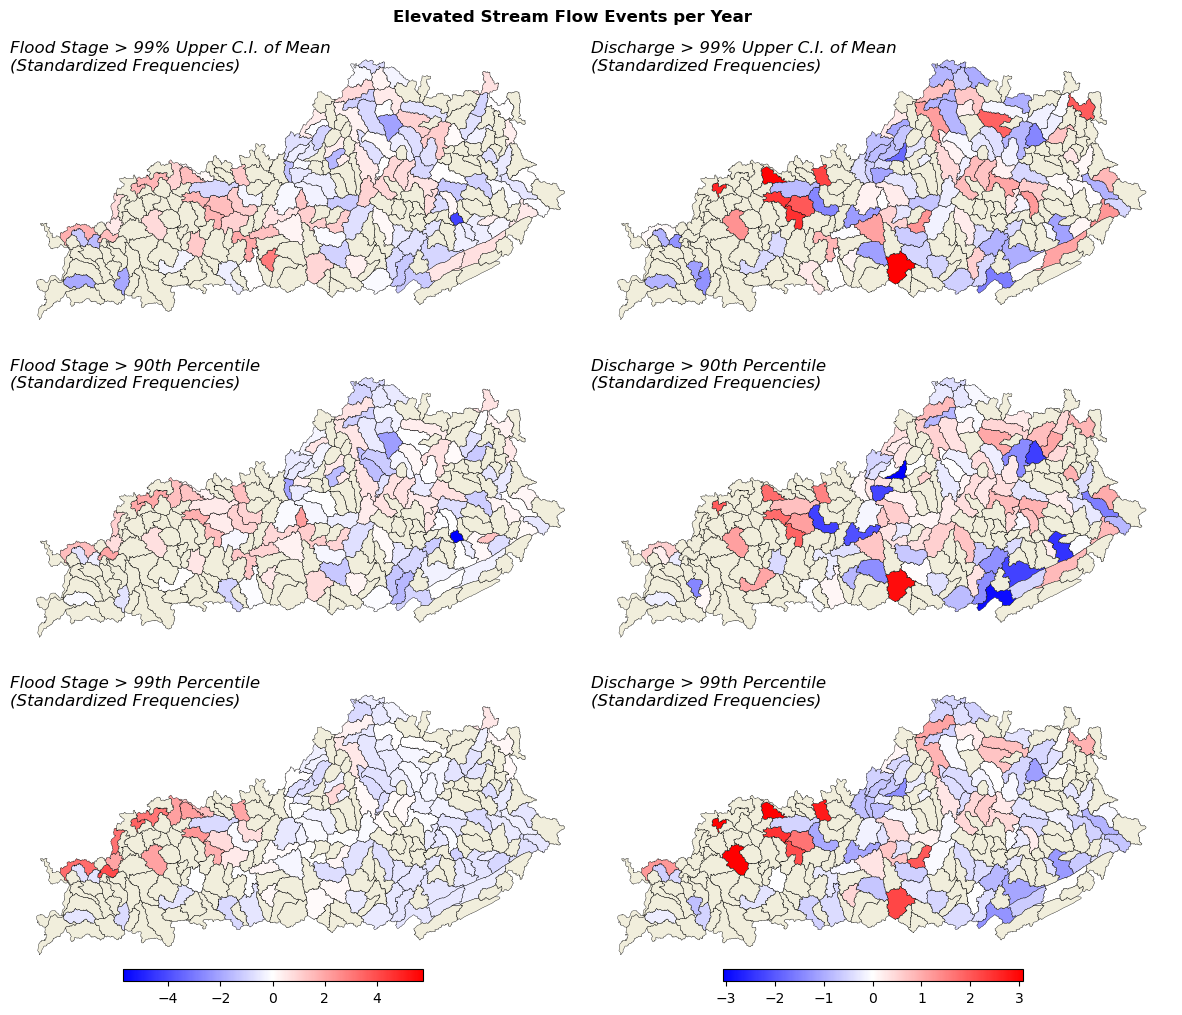

In [84]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,12))

ax = ax.ravel()

cmap = 'bwr'

gh_cols = [col for col in gdf_ws if 'gh_std' in col]
gh_min = gdf_ws[gh_cols].min().min()
# gh_max = gdf_ws[gh_cols].max().max()
norm_gh = mpl.colors.Normalize(vmin=gh_min, vmax=-gh_min)

sf_cols = [col for col in gdf_ws if 'sf_std' in col]
sf_min = gdf_ws[sf_cols].min().min()
# sf_max = gdf_ws[sf_cols].max().max()
norm_sf = mpl.colors.Normalize(vmin=sf_min, vmax=-sf_min)

for i, std_col in enumerate(sorted([col for col in gdf_ws if ('std' in col)])):

    if 'gh' in std_col:
        data_type='Flood Stage'
        norm = norm_gh
    else:
        data_type='Discharge'
        norm = norm_sf

    gdf_ws.plot(ax=ax[i], column=std_col, linewidth=0.25, edgecolor='k', cmap=cmap,
                missing_kwds={'color':'#F1EEDC', 'linewidth':0.25, 'edgecolor':'k', 'label':'Insufficient Data'}, 
                legend=False, 
                norm=norm,
                # legend_kwds={'fontsize':8, 'frameon':False, 'loc':'upper left', 'bbox_to_anchor':(0,1), 'ncols':1}
               )

    if 'moe' in std_col:
        threshold = std_col[3:5] +'% Upper C.I. of Mean'
    else:
        threshold = std_col[10:12] + 'th Percentile'

    figure_title = f'\n{data_type} > {threshold}\n(Standardized Frequencies)'
    ax[i].set_title(label=figure_title, style='italic', loc='left', y=0.89)
    ax[i].set_axis_off()

# # Create an array of ticks from the floor of min to the ceiling of max, plus include min and max explicitly
# gh_int_ticks = np.arange(np.floor(gh_min), np.ceil(gh_max) + 1)[2:-2]
# gh_all_ticks = np.sort(np.unique(np.concatenate(([gh_min, gh_max], gh_int_ticks))))  # Combine and sort

cbar_gh = fig.add_axes([0.2, 0.1, 0.2, 0.01])     # [left, bottom, width, height]
sm_gh = mpl.cm.ScalarMappable(cmap=cmap, norm=norm_gh)
sm_gh.set_array([])
fig.colorbar(sm_gh, cax=cbar_gh, orientation='horizontal')
# cbar_gh.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))

cbar_sf = fig.add_axes([0.6, 0.1, 0.2, 0.01])     # [left, bottom, width, height]
sm_sf = mpl.cm.ScalarMappable(cmap=cmap, norm=norm_sf)
sm_sf.set_array([])
fig.colorbar(sm_sf, cax=cbar_sf, orientation='horizontal')

plt.suptitle('Elevated Stream Flow Events per Year', weight='bold', y=0.91)
plt.subplots_adjust(hspace=0.1, wspace=0)
plt.show()

## K-means Clusters

In [11]:
# cluster_labels_path = r'HUC10_KMeans.csv'
cluster_labels_path = r'/Users/Matthew/Desktop/noise_assigned_data_hdbscan.csv'

df_clusters = pd.read_csv(cluster_labels_path)

# df_clusters.drop(columns=df_clusters.columns[0], inplace=True)

df_clusters.head()

,huc10,Clusters
0,507020103,18
1,507020105,18
2,507020106,18
3,507020202,17
4,507020205,2


In [14]:
df_clusters['Clusters'].value_counts()

Clusters
2     8
18    7
22    7
52    7
24    7
     ..
45    2
21    2
44    2
38    2
31    2
Name: count, Length: 62, dtype: int64

## Join Clusters with Watersheds

In [12]:
gdf_kmeans = pd.merge(gdf_ws, df_clusters, how='left', on='huc10', suffixes=[''])

gdf_kmeans.head()

,huc10,geometry,moe99_freq_gh,percentile90_freq_gh,percentile99_freq_gh,moe99_freq_gh_std,percentile90_freq_gh_std,percentile99_freq_gh_std,moe99_freq_sf,percentile90_freq_sf,percentile99_freq_sf,moe99_freq_sf_std,percentile90_freq_sf_std,percentile99_freq_sf_std,Clusters
0,507020303,"POLYGON ((881893.974 4190800.677, 881967.969 4...",81.522059,43.305147,6.823529,-0.559426,0.033010,-0.334038,39.620000,26.680000,3.720000,-0.915059,-1.545175,-0.906152,18
1,509010110,"POLYGON ((894401.028 4297112.227, 894422.866 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37
2,510010111,"POLYGON ((744167.531 4274338.915, 744182.905 4...",107.882353,42.882353,7.411765,1.026374,-0.042376,-0.195679,99.347826,44.869565,8.304348,1.872336,1.037348,0.706650,41
3,510010113,"POLYGON ((715947.500 4329577.477, 715938.418 4...",95.093869,40.549083,6.264037,0.257036,-0.458404,-0.465635,46.921520,35.574235,5.221477,-0.574310,-0.282387,-0.377923,15
4,509020302,"POLYGON ((698694.100 4338269.383, 698724.859 4...",78.836601,38.748366,6.467320,-0.720979,-0.779476,-0.417821,41.670000,34.827059,4.917647,-0.819390,-0.388470,-0.484812,5


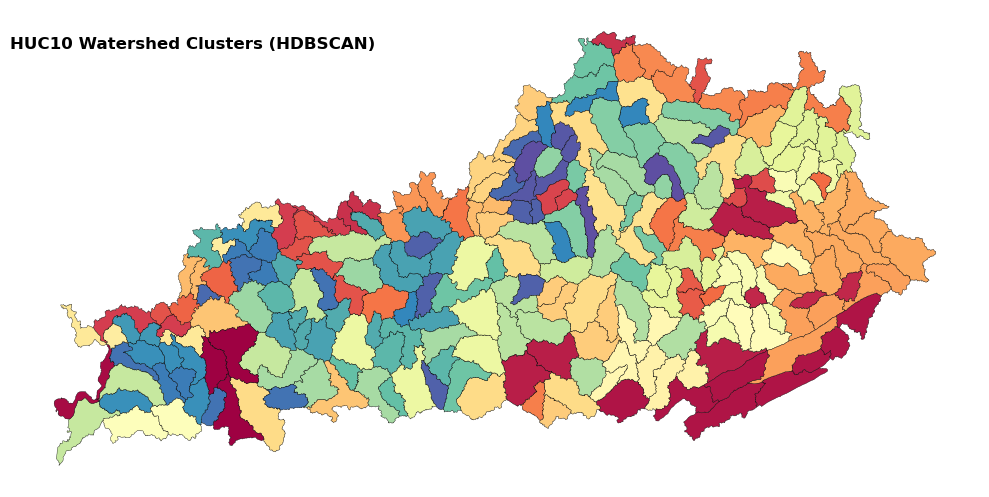

In [22]:
fix, ax = plt.subplots(figsize=(10,7))

# define colormap for watershed polygons
# cluster_colors = ListedColormap(['#C0D6E8', '#FBF8DD', '#E9C874', '#A34343'], 'cluster_colors')

# gdf_kmeans.plot(column='Clusters', ax=ax, legend=False, linewidth=0.25, edgecolor='k', cmap=cluster_colors)
gdf_kmeans.plot(column='Clusters', ax=ax, legend=False, linewidth=0.25, edgecolor='k', cmap='Spectral')


# # create custom legend handles
# legend_handles = [Patch(facecolor='#C0D6E8', edgecolor='k', linewidth=0.25, label='0'), 
#                   Patch(facecolor='#FBF8DD', edgecolor='k', linewidth=0.25, label='1'), 
#                   Patch(facecolor='#E9C874', edgecolor='k', linewidth=0.25, label='2'), 
#                   Patch(facecolor='#A34343', edgecolor='k', linewidth=0.25, label='3')]

# # add legend with custom legend handles
# ax.legend(handles=legend_handles, bbox_to_anchor=(0, 0.8), loc='center left', frameon=False)


ax.set_title('HUC10 Watershed Clusters (HDBSCAN)', weight='bold', loc='left', y=0.9)

ax.set_axis_off()
plt.tight_layout()
plt.show()

## Distributions of Events by Cluster

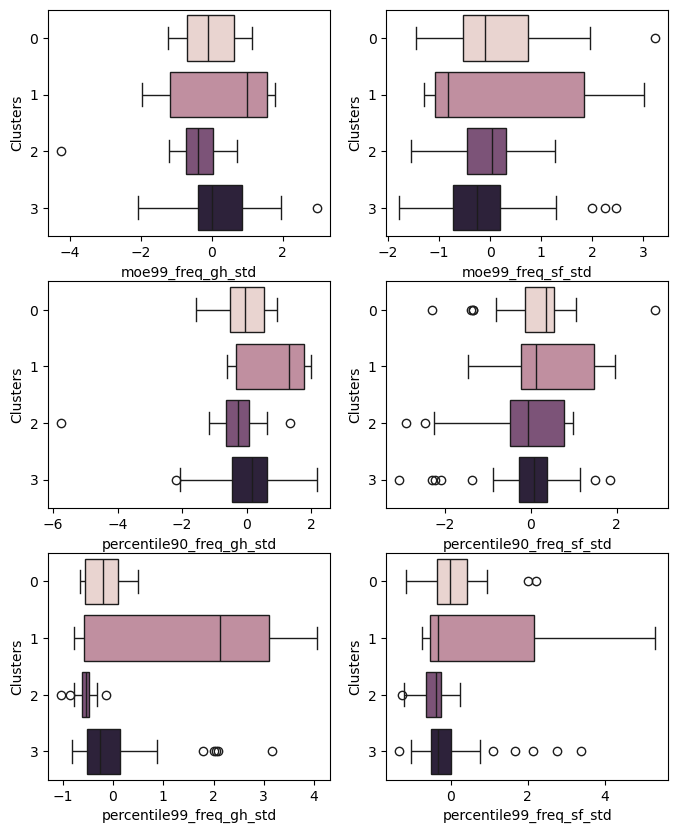

In [115]:
fix, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,10))

ax = ax.ravel()

for i, std_col in enumerate(sorted([col for col in gdf_kmeans if 'std' in col])):
    
    sns.boxplot(data=gdf_kmeans, x=std_col, y='Clusters', hue='Clusters', orient='h', ax=ax[i], legend=False)

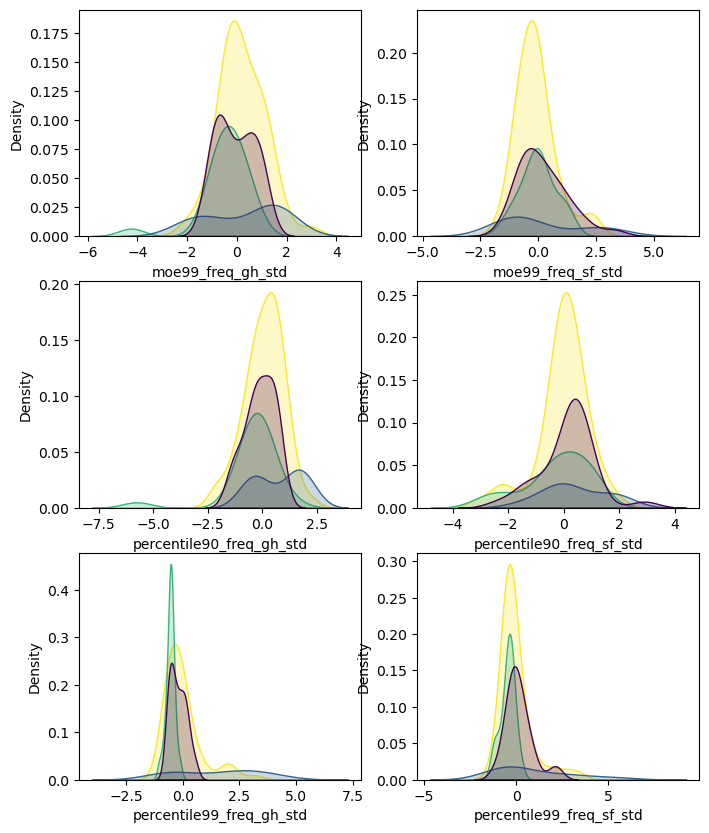

In [124]:
fix, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,10))

ax = ax.ravel()

for i, std_col in enumerate(sorted([col for col in gdf_kmeans if 'std' in col])):
    
    sns.kdeplot(data=gdf_kmeans, x=std_col, hue='Clusters', fill=True, ax=ax[i], palette='viridis', legend=False)

# Statistical Comparison

## One-way ANOVA

In [128]:
# Define the model
for std_col in sorted([col for col in gdf_kmeans if 'std' in col]):
    model = ols(f'{std_col} ~ C(Clusters)', data=gdf_kmeans).fit()
    anova_results = sm.stats.anova_lm(model, typ=1)
    print(std_col)
    print(anova_results)
    print('\n')

moe99_freq_gh_std
                df      sum_sq   mean_sq        F    PR(>F)
C(Clusters)    3.0    7.842058  2.614019  2.70519  0.048694
Residual     114.0  110.157942  0.966298      NaN       NaN


moe99_freq_sf_std
                df      sum_sq   mean_sq         F    PR(>F)
C(Clusters)    3.0    2.085564  0.695188  0.682855  0.564446
Residual     106.0  107.914436  1.018061       NaN       NaN


percentile90_freq_gh_std
                df      sum_sq   mean_sq         F    PR(>F)
C(Clusters)    3.0   13.189574  4.396525  4.782003  0.003551
Residual     114.0  104.810426  0.919390       NaN       NaN


percentile90_freq_sf_std
                df      sum_sq   mean_sq         F    PR(>F)
C(Clusters)    3.0    3.687821  1.229274  1.225664  0.304092
Residual     106.0  106.312179  1.002945       NaN       NaN


percentile99_freq_gh_std
                df     sum_sq    mean_sq          F        PR(>F)
C(Clusters)    3.0  37.386479  12.462160  17.623423  1.817547e-09
Residual     114.0  

## Pairwise Comparisons if ANOVA significant

In [133]:
# Let's assume 'df' is your DataFrame with a normal distribution for the variable of interest
# and it contains a continuous variable 'value' and a categorical variable 'group'

for std_col in sorted([col for col in gdf_kmeans if 'std' in col]):

    valid_data = gdf_kmeans[std_col].dropna()
    clusters = gdf_kmeans.loc[valid_data.index.values, 'Clusters']

    tukey_results = pairwise_tukeyhsd(endog=valid_data,
                                      groups=clusters,
                                      alpha=0.05)
    
    print(std_col)
    print(tukey_results.summary())
    print('\n')
    
    # Plot the results
    # tukey_results.plot_simultaneous() 

moe99_freq_gh_std
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.3283 0.7494 -0.5272 1.1837  False
     0      2  -0.4048  0.456 -1.1204 0.3108  False
     0      3   0.2463 0.6994 -0.3457 0.8383  False
     1      2  -0.7331  0.144 -1.6224 0.1563  False
     1      3  -0.0819 0.9931 -0.8752 0.7113  False
     2      3   0.6512 0.0445  0.0112 1.2911   True
---------------------------------------------------


moe99_freq_sf_std
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0003    1.0 -0.9699 0.9706  False
     0      2  -0.2146  0.882 -0.9749 0.5456  False
     0      3  -0.3075 0.5676  -0.927 0.3119  False
     1      2   -0.215 0.9451 -1.2269  0.797  False
     1      3  -0.3078 0.8141 -1.2187  0.603  False
     2      3  -0.0929 0.9